In [1]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt

from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display

from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

In [2]:
#Reads in all the results in the "modelName" folder
def read_result(model_name, result_name):
    data = []
    result_data_dir = get_result_model(model_name)
    for i, folder_name in enumerate(os.listdir(result_data_dir)):
        try:
            if folder_name.startswith("params"):
                folder_path = os.path.join(result_data_dir, folder_name)
                file_path = os.path.join(folder_path, f"{result_name}.parquet.brotli")
                print(os.path.basename(folder_path))
                data.append(pd.read_parquet(file_path))
        except:
            continue
    return pd.concat(data, axis=0).reset_index(drop=True)

#Calculates the product of the daily_ic_mean and maximum overall IC in each result to find the best performing model
def get_max_ic(data):
    collection={}
    for index, row in data.iterrows():
        collection[max(row.loc[(row.index.str.startswith("dIC"))])]=index
    max_ic_idx=collection[max(list(collection.keys()))]
    return data.iloc[max_ic_idx]

#Gets the files of the best performing model
def get_max_ic_file(data, model_name):
    files = {}
#     param_names = ['max_depth', 'learning_rate', 'num_leaves', 'feature_fraction', 'min_gain_to_split', 'min_data_in_leaf', 'lambda_l1', 'lambda_l2']
#     param_vals = data.loc[param_names]
    time_index = data.to_frame().index.get_loc('time')
    param_vals = data.iloc[:time_index].values
#     key = [f'{p}' for i, p in enumerate(param_vals) if i==1 or i==3 or i==4 or i==6 or i==7] + [f'{int(p)}' for i, p in enumerate(param_vals) if i==0 or i==2 or i==5]
#     key = [key[4], key[0], key[5], key[1], key[2], key[6], key[3], key[4]]
    key = [f'{float(p)}' for p in (param_vals)]
    key = '_'.join(key)
    
    result_data_dir = get_result_model(model_name) / f'params_{key}'
    for file in os.listdir(result_data_dir):
        if file.endswith(".parquet.brotli"):
            files[extract_first_string(file)]=pd.read_parquet(os.path.join(result_data_dir, file))
        elif file.endswith(".png"):
            img = os.path.join(result_data_dir, file)
            files[extract_first_string(file)]=Image(img)
    return files

def get_all(model_name):
    return get_max_ic_file(get_max_ic(read_result(model_name, 'metrics')), model_name)

def sign_accuracy(predictions, actual, target_sign, pred):
    accuracies = []  # To store accuracies for each ticker
    
    # Iterate through each ticker and calculate accuracy
    for ticker in predictions.index.levels[0]:
        ticker_group = predictions.loc[ticker]
        actual_group = actual.loc[ticker]
        
        # Determine if each pair has the same sign
        if pred == 'price':
            correct_signs = (np.sign(ticker_group) == np.sign(actual_group))
        elif pred == 'sign':
            correct_signs = (ticker_group == np.sign(actual_group))
            
        # Filter by target sign if specified
        if target_sign == 'positive':
            mask = (np.sign(actual_group) == 1)
            correct_signs = correct_signs[mask]
        elif target_sign == 'negative':
            mask = (np.sign(actual_group) == -1)
            correct_signs = correct_signs[mask]
        
        # Calculate the accuracy and store it
        accuracy = np.mean(correct_signs) * 100  # Convert to percentage
        accuracies.append(accuracy)
        
    # Calculate and return the mean accuracy across all tickers
    mean_accuracy = np.nanmean(accuracies)
    return mean_accuracy

In [3]:
def price(best_model_params):
    #Gets the predictions of the highest overall IC in the boosted round cases
    best_prediction=best_model_params['predictions'][str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("dIC")].idxmax(axis=1)[0]))].to_frame()
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'returns']
    #Shift actual returns 1 day back
    merged.returns = merged.returns.shift(-1)
    merged = merged.dropna()
    print('Best num_iterations: ' + str(best_prediction.columns[0]))
    print(f"Neutral Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, None, 'price'), 2)}%")
    print(f"Positive Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'price'), 2)}%")
    print(f"Negative Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'price'), 2)}%")
    display(best_model_params['metrics'])
    return merged

def sign(best_model_params):
    #Gets the predictions of the highest overall IC in the boosted round cases
    best_prediction=best_model_params['predictions'][str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("dAS")].idxmax(axis=1)[0]))].to_frame()
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'returns']
    #Shift actual returns 1 day back
    merged.returns = merged.returns.shift(-1)
    merged = merged.dropna()
    print('Best num_iterations: ' + str(best_prediction.columns[0]))
    print(f"Neutral Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, None, 'sign'), 2)}%")
    print(f"Positive Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'sign'), 2)}%")
    print(f"Negative Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'sign'), 2)}%")
    display(best_model_params['metrics'])
    return merged

In [4]:
#Retrieves the files of the best performing model
best_model_params = get_all('lightGBM_trial_26')

params_-1.0_0.15_15.0_0.85_0.02_60.0_0.0_0.01_1.0_0.0


In [ ]:
merged = price(best_model_params)

Best num_iterations: 150


In [ ]:
#Processes each period within in the backest
def process_period(period, period_returns, nStocks, candidates):
    #Find sp500 candidates for given year and assign it to data
    period_year = period.index.get_level_values('date')[0].year
    sp500 = candidates[period_year]
    tickers = common_tickers(sp500, period)
    sp500_period = period.loc[tickers]
    print("----------------------------------------------")
    print(period_year)
    print('Num of tickers: ' + str(len(tickers)))
    
    #Long and short n stocks and add to periodReturns dataframe
    for date, stocks in sp500_period.groupby('date'):
        long_stocks = stocks.predictions.nlargest(nStocks).index.get_level_values('ticker')
        short_stocks = stocks.predictions.nsmallest(nStocks).index.get_level_values('ticker')
        long_ret = stocks.loc[long_stocks].returns.values
        short_ret = stocks.loc[short_stocks].returns.values
        period_returns.loc[date] = [long_stocks.tolist(), long_ret, short_stocks.tolist(), short_ret]

    
#Backtest
def backtest(data, nStocks):
    #Set portfolio weights and other tracking variables
    period_returns = pd.DataFrame(columns=['longStocks', 'longRet', 'shortStocks', 'shortRet'])
    tickers = data.index.get_level_values('ticker')
    predictions_idx = []
    prev_ticker = None
    default_end = data.index[-1][1] + timedelta(days=1)

    #Get candidates
    candidates = get_candidate()

    #endDate default is the last date of the time frame + one
    end_date = default_end

    #Find each period and execute processPeriod()
    for i, ticker in enumerate(tickers):
        if data.index[i][1] > end_date:
            process_period(data.iloc[predictions_idx], period_returns, nStocks, candidates)
            predictions_idx = []
            end_date = default_end

        #Setting endDate by getting the date whenever the ticker changes from the first ticker in the dataset
        if prev_ticker == data.index[0][0] and ticker != data.index[0][0]:
            end_date = data.index[i-1][1]

        prev_ticker = ticker
        predictions_idx.append(i)

        if i == len(tickers) - 1:
            process_period(data.iloc[predictions_idx], period_returns, nStocks, candidates)
            
    return period_returns

In [ ]:
merged_fix = set_timeframe(merged, '2018-01-01', '2022-01-01')

In [ ]:
%%time
#Perform backtest
pred_return = backtest(merged, nStocks=100)

In [ ]:
def hrp(returns):
    def correl_dist(corr):
        # A distance matrix based on correlation, where 0<=d[i,j]<=1
        # This is a proper distance metric
        dist = ((1 - corr) / 2.)**.5  # distance matrix
        dist = squareform(dist)
        return dist

    def get_quasi_diag(link):
        # Sort clustered items by distance
        link = link.astype(int)
        sortIx = pd.Series([link[-1, 0], link[-1, 1]])
        numItems = link[-1, 3]  # number of original items
        while sortIx.max() >= numItems:
            sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
            df0 = sortIx[sortIx >= numItems]  # find clusters
            i = df0.index
            j = df0.values - numItems
            sortIx[i] = link[j, 0]  # item 1
            """df0 = pd.Series(link[j, 1], index=i + 1)
            sortIx = sortIx.append(df0)  # item 2
            sortIx = sortIx.sort_index()  # re-sort
            sortIx.index = range(sortIx.shape[0])  # re-index"""
            df1 = pd.Series(link[j, 1], index=(i + 1).tolist())
            sortIx = pd.concat([sortIx, df1]).sort_index()
            sortIx.index = range(sortIx.shape[0])
        return sortIx.tolist()

    def get_cluster_var(cov, cItems):
        # Compute variance per cluster
        cov_= cov.loc[cItems,cItems] # matrix slice
        # Compute the inverse_variance portfolio
        ivp = 1. / np.diag(cov_)
        ivp /= ivp.sum()
        w_= ivp.reshape(-1,1)
        cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
        return cVar

    def get_rec_bipart(cov, sortIx):
        # Compute HRP alloc
        w = pd.Series(1, index=sortIx)
        cItems = [sortIx]  # initialize all items in one cluster
        while len(cItems) > 0:
            cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
            for i in range(0, len(cItems), 2):  # parse in pairs
                cItems0 = cItems[i]  # cluster 1
                cItems1 = cItems[i + 1]  # cluster 2
                cVar0 = get_cluster_var(cov, cItems0)
                cVar1 = get_cluster_var(cov, cItems1)
                alpha = 1 - cVar0 / (cVar0 + cVar1)
                w[cItems0] *= alpha  # weight 1
                w[cItems1] *= 1 - alpha  # weight 2
        return w
    
    cov, corr = returns.cov(), returns.corr()
    # Construct a hierarchical portfolio
    dist = correl_dist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = get_quasi_diag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = get_rec_bipart(cov, sortIx)
    return hrp.sort_index().values

def ivp(returns):
    # Compute the inverse-variance portfolio
    cov = returns.cov()
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def ewp(returns):
    weight = 1/len(returns.columns)
    return np.full(len(returns.columns), weight)

def mvp(returns):
    cov = returns.cov()
    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(list(wt))

In [ ]:
@timebudget
def port_opt(data, window_size, port_opt_func, option):
    assert port_opt_func==ewp or port_opt_func==hrp or port_opt_func==mvp or port_opt_func==ivp, 'Must use callable function ewp, hrp, mvp, or ivp'
    @ray.remote
    def exec_port_opt(i, data, window_size, port_opt_func, option):
        if option == 'long':  
            long_returns = pd.DataFrame(data['longRet'][i:i+window_size].tolist())
            long_weights = port_opt_func(long_returns)
            total_ret = np.sum(long_returns.iloc[-1] * long_weights)
        elif option == 'short':
            short_returns = -1 * pd.DataFrame(data['shortRet'][i:i+window_size].tolist())
            short_weights = port_opt_func(short_returns)
            total_ret = np.sum(short_returns.iloc[-1] * short_weights)
        elif option == 'both':
            long_returns = pd.DataFrame(data['longRet'][i:i+window_size].tolist())
            long_weights = port_opt_func(long_returns)
            
            short_returns = -1 * pd.DataFrame(data['shortRet'][i:i+window_size].tolist())
            short_weights = port_opt_func(short_returns)
            total_ret = np.sum(long_returns.iloc[-1] * long_weights) + np.sum(short_returns.iloc[-1] * short_weights)
        
        return total_ret

    window_size = 21
    ray.init(num_cpus=16, ignore_reinit_error=True)
    total_ret_collect = ray.get([exec_port_opt.remote(i, data, window_size, port_opt_func, option) for i in range(0, len(data) - window_size + 1)])
    ray.shutdown()
    
    total_ret_data = data[window_size-1:]
    total_ret_data['totalRet'] = total_ret_collect
    return total_ret_data

In [11]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='both')

2023-09-01 20:59:20,318	INFO worker.py:1636 -- Started a local Ray instance.


port_opt took 33.032sec


In [12]:
#Get SPY returns (matching timeframe as our backtest)
spy_return = get_spy(start_date=pred_return_opt.index[0]-timedelta(days=1), end_date=pred_return_opt.index[-1]+timedelta(days=1))

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2017-02-02   2017-02-02
End Period                 2021-12-01   2021-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          97.92%       93.78%
CAGR﹪                     10.25%       9.92%

Sharpe                     0.84         1.06
Prob. Sharpe Ratio         96.32%       99.31%
Smart Sharpe               0.74         0.93
Sortino                    1.14         1.8
Smart Sortino              1.01         1.58
Sortino/√2                 0.81         1.27
Smart Sortino/√2           0.71         1.12
Omega                      1.27         1.27

Max Drawdown               -34.1%       -18.52%
Longest DD Days            218          485
Volatility (ann.)          19.11%       13.83%
R^2                        0.0          0.0
Information Ratio          -0.0         -0.0
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-10,2020-03-17,2020-03-23,14,-18.517518,-16.562092
2,2021-09-24,2021-12-01,2021-12-01,69,-9.098859,-8.908039
3,2020-06-11,2020-09-30,2021-01-04,208,-8.854444,-8.435107
4,2019-08-12,2019-10-08,2020-02-20,193,-8.307410,-7.844017
5,2020-03-25,2020-04-03,2020-04-07,14,-7.941763,-7.102383


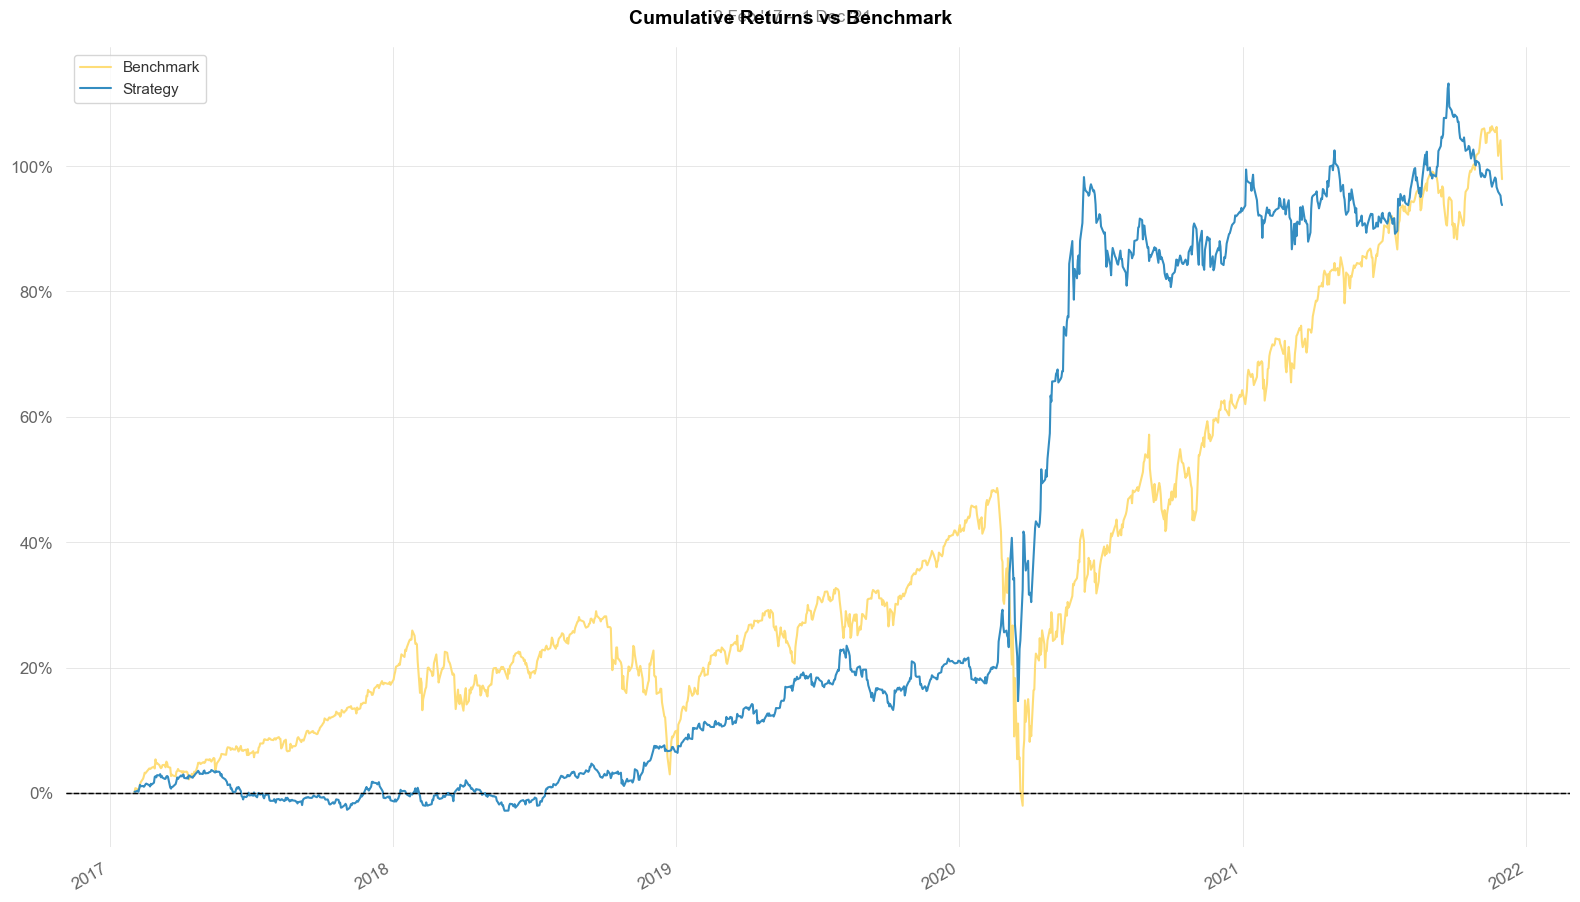

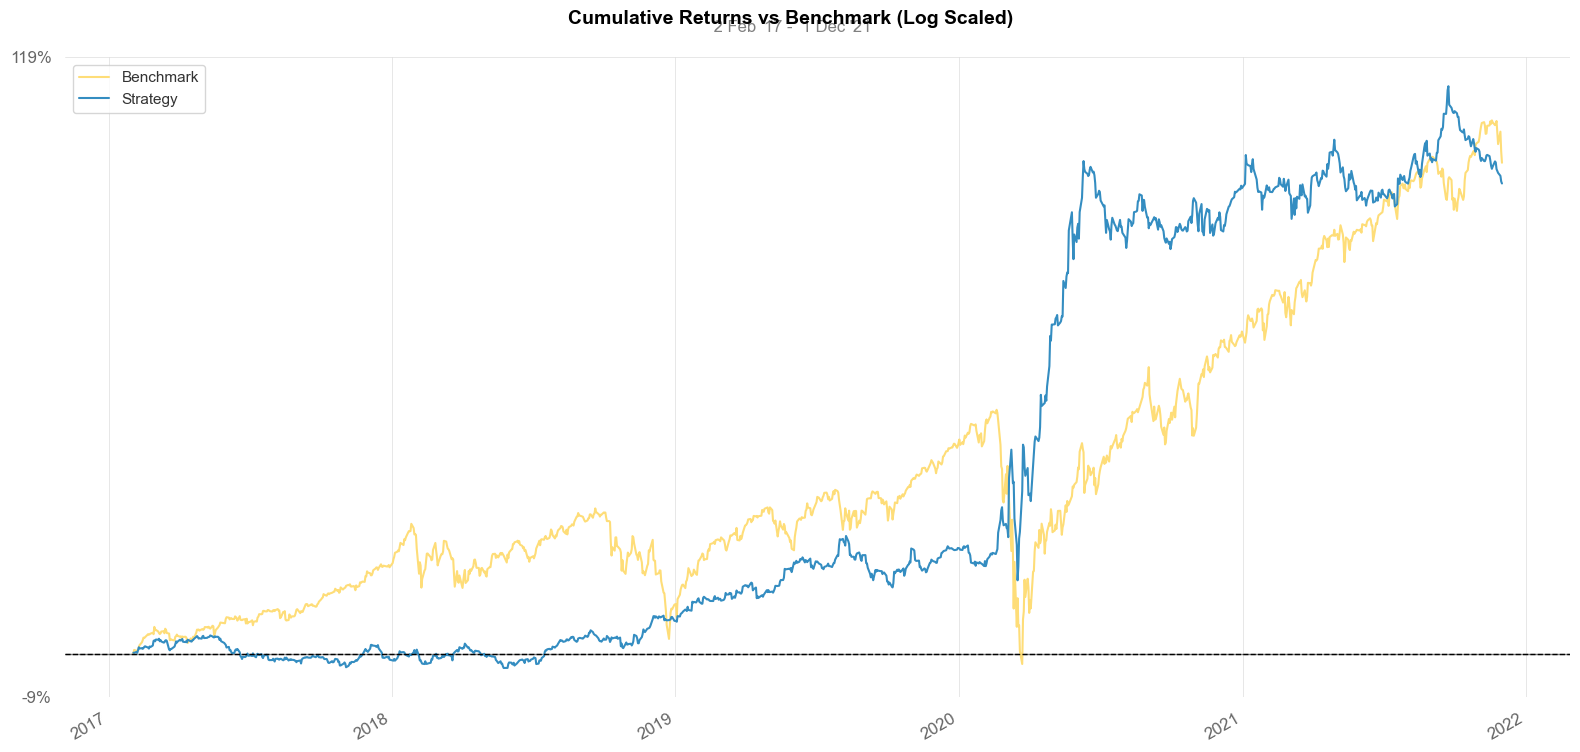

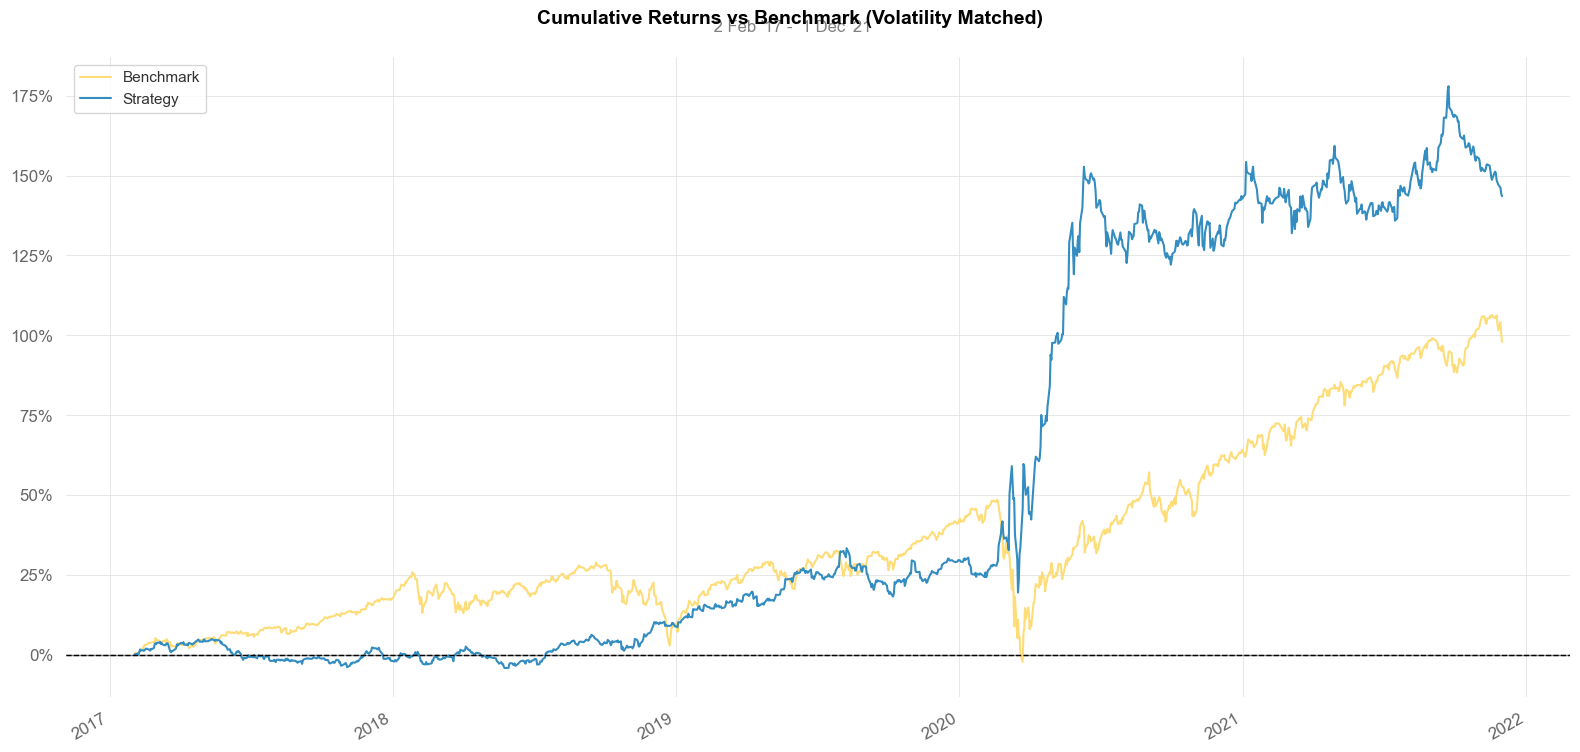

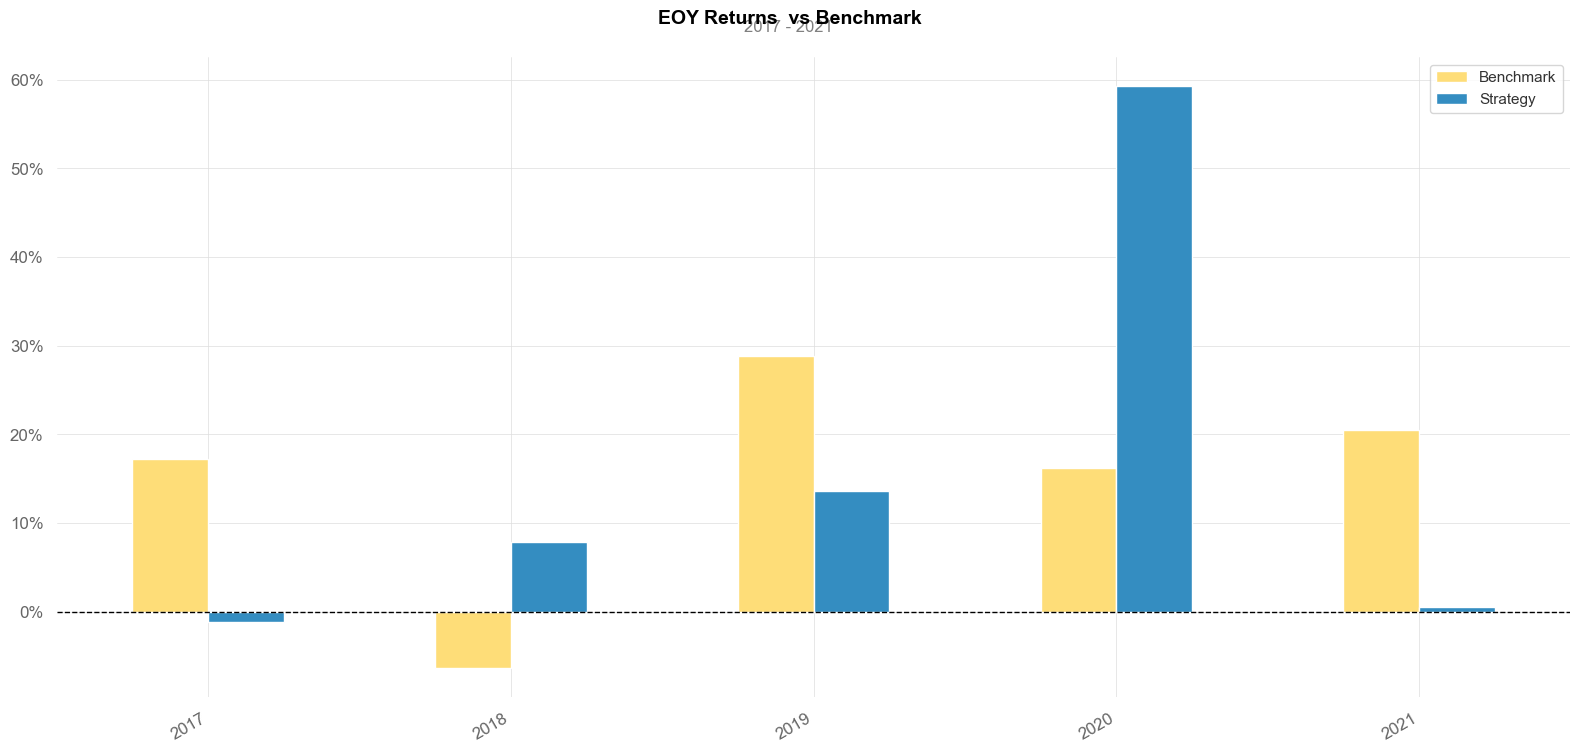

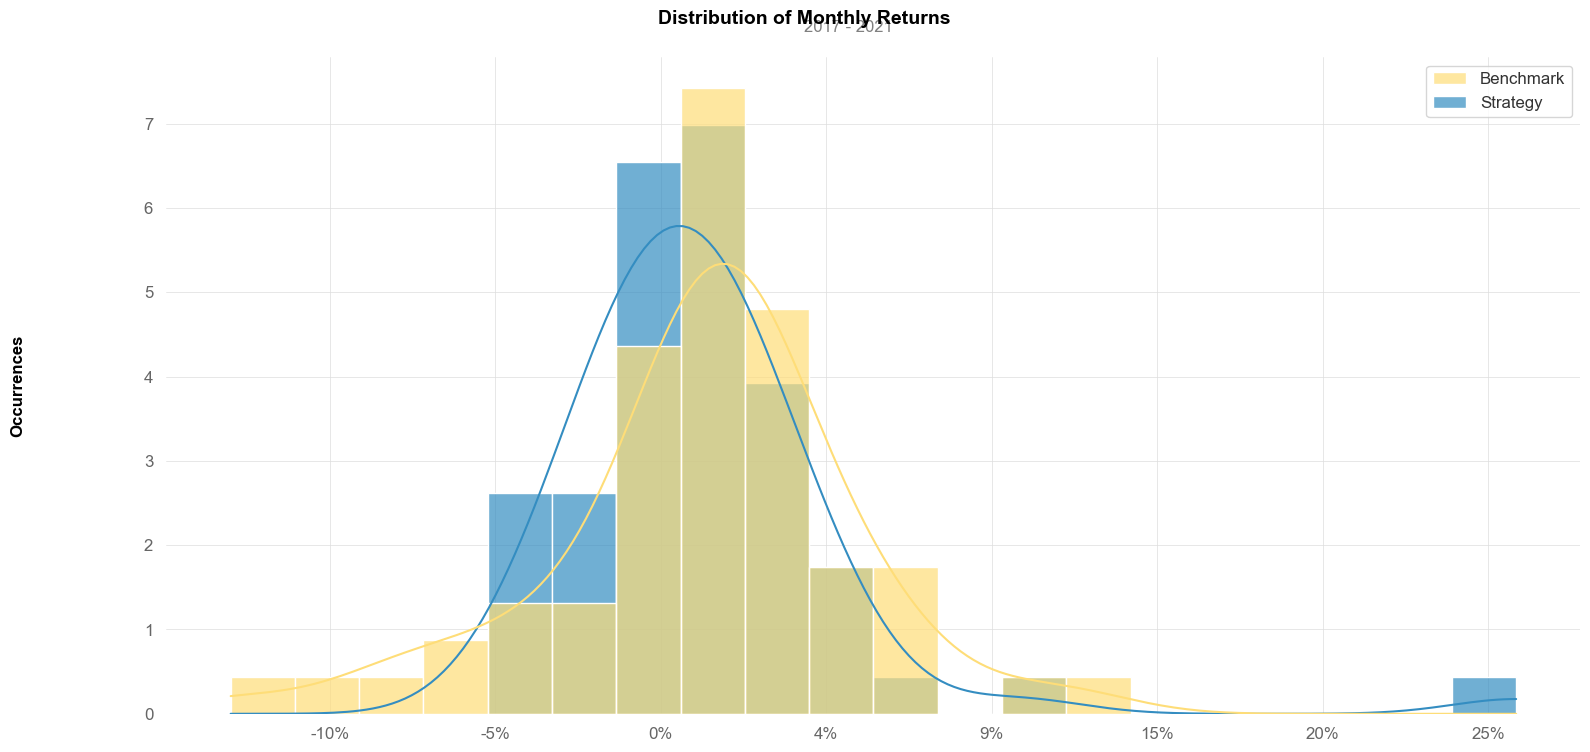

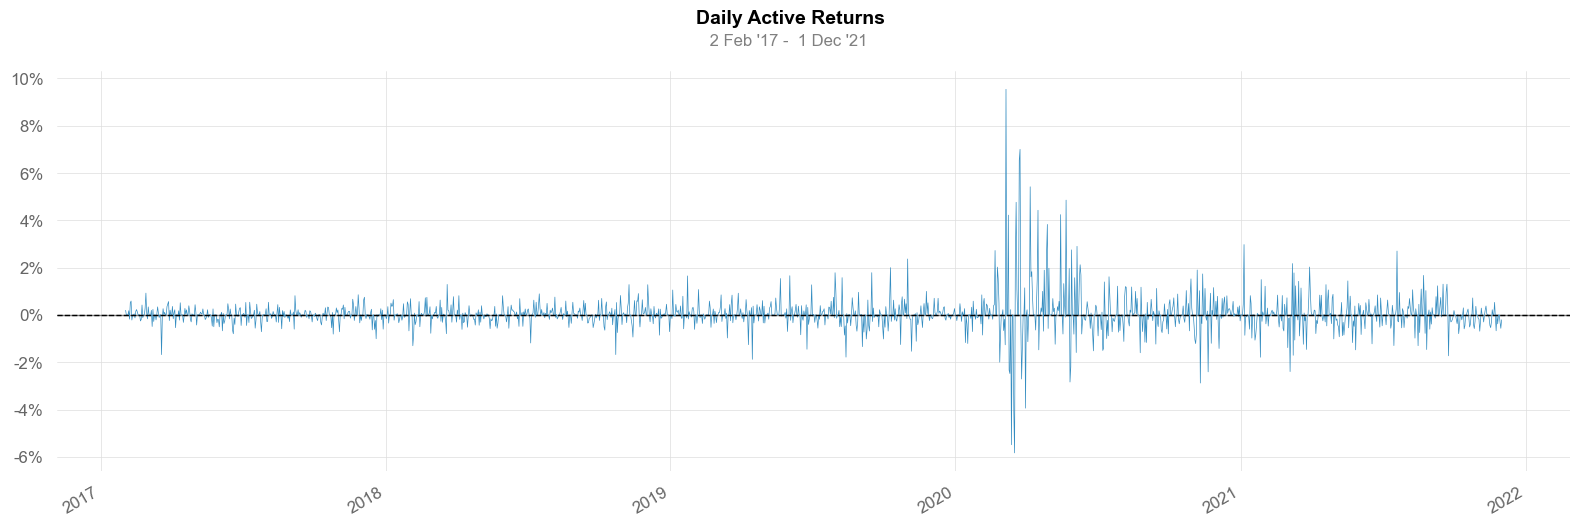

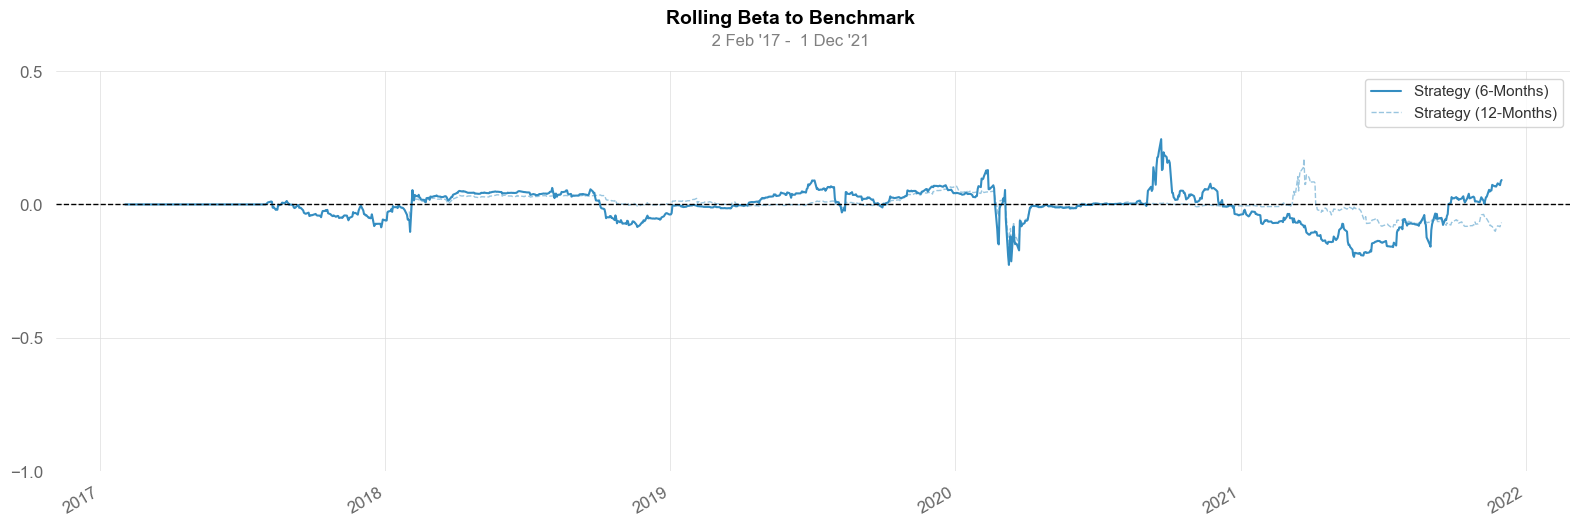

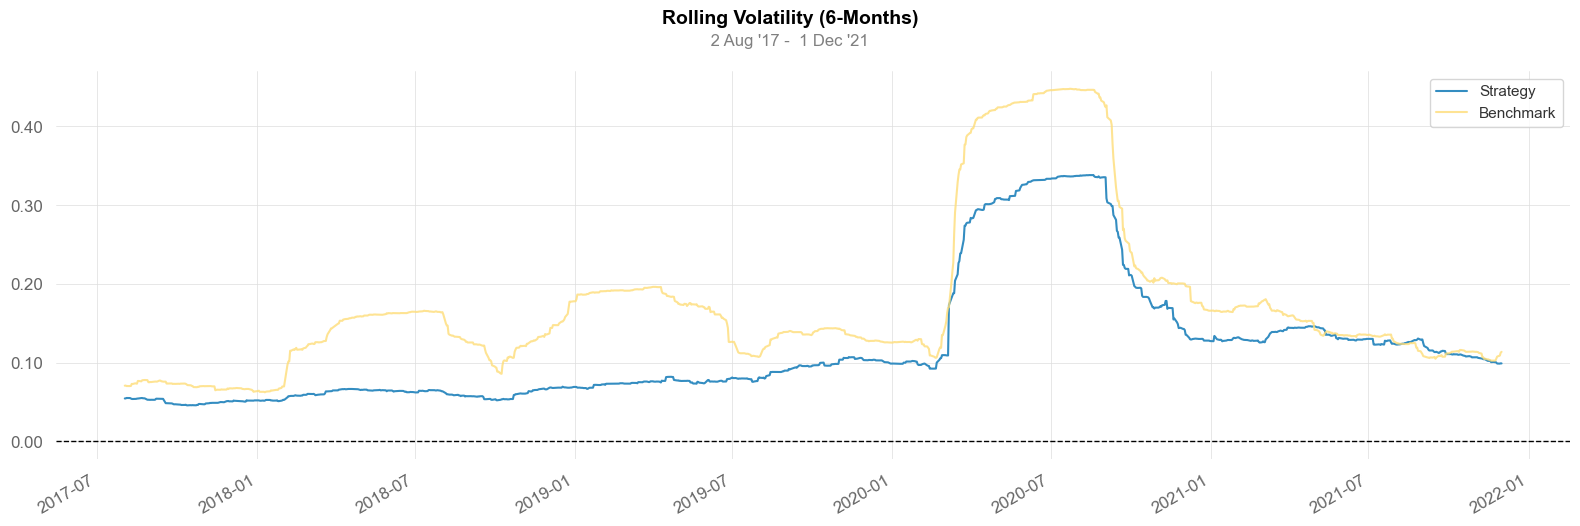

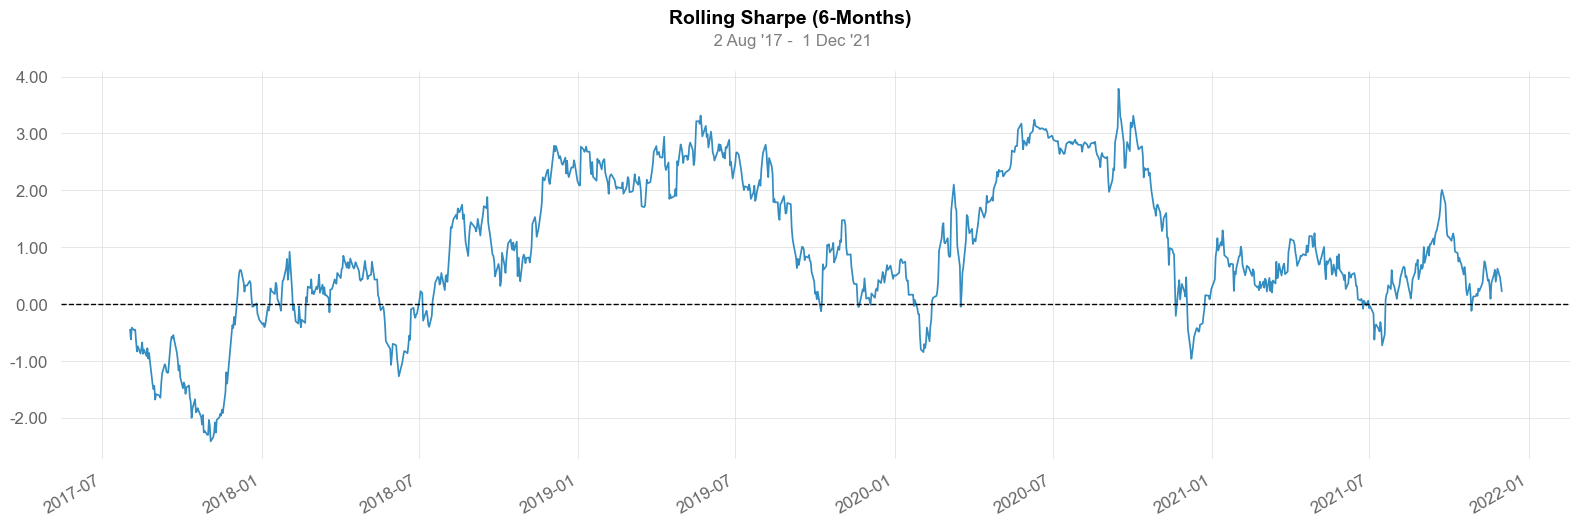

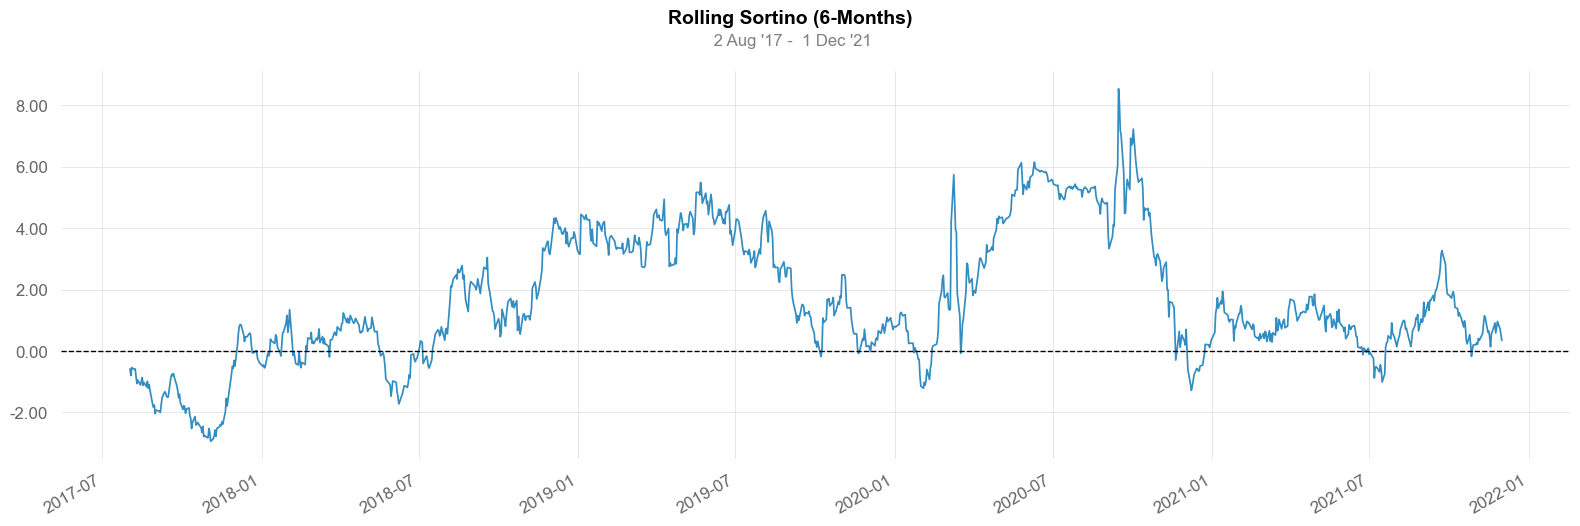

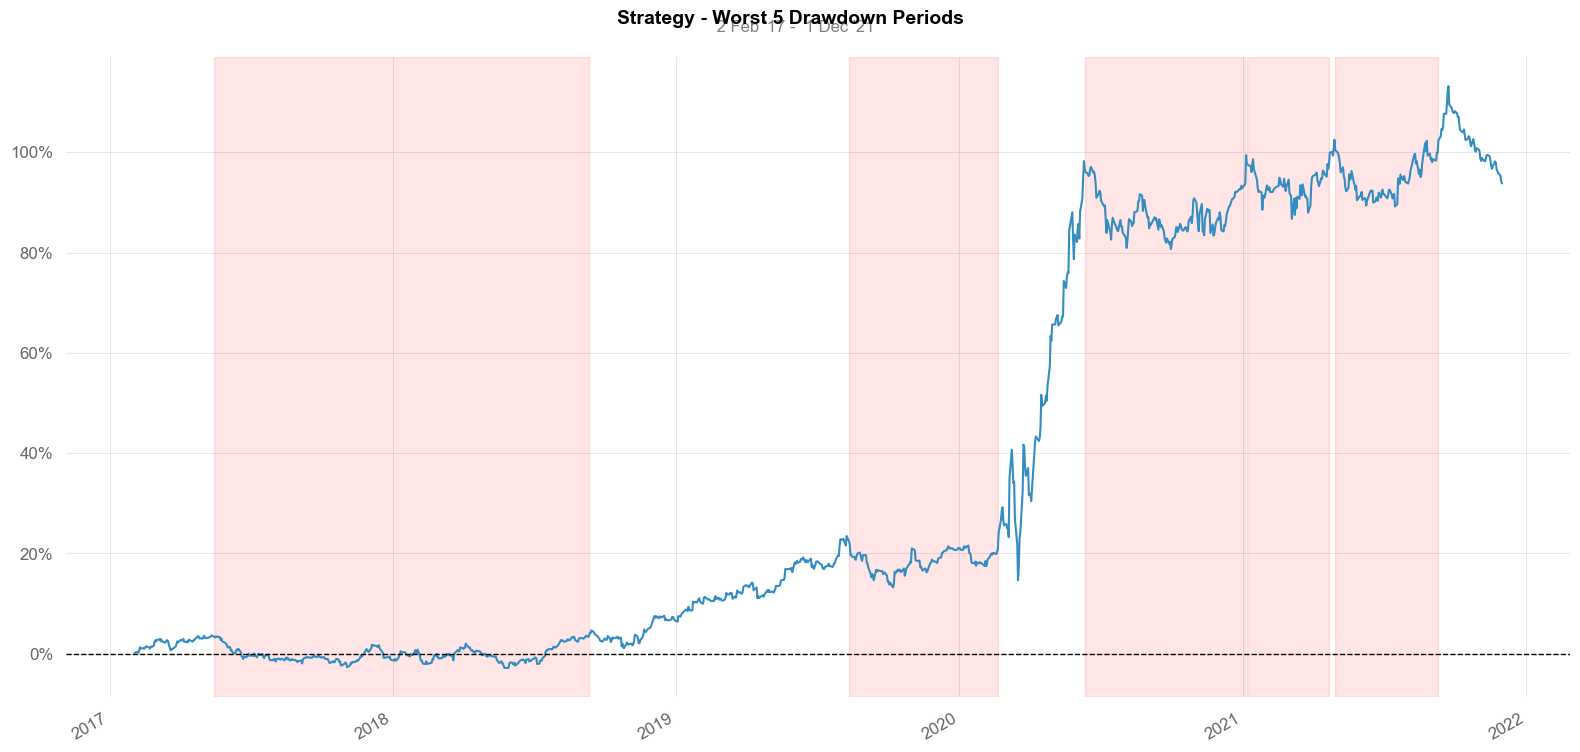

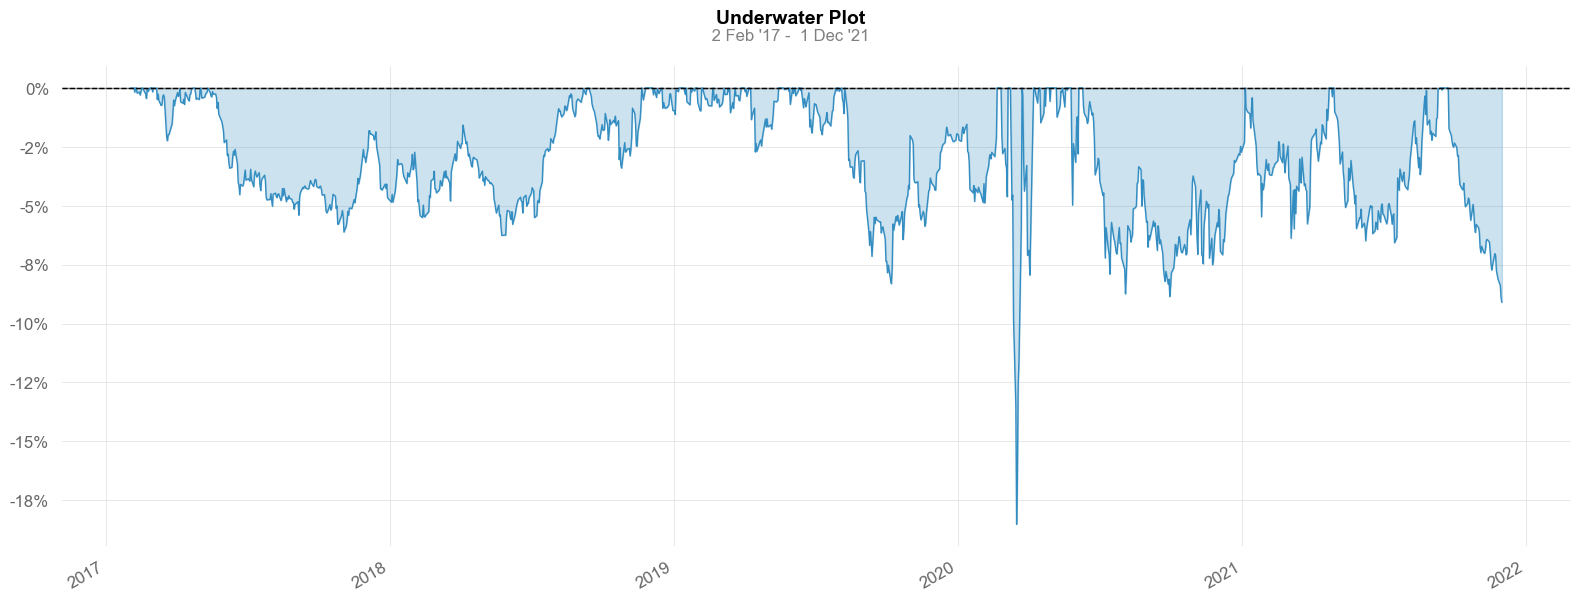

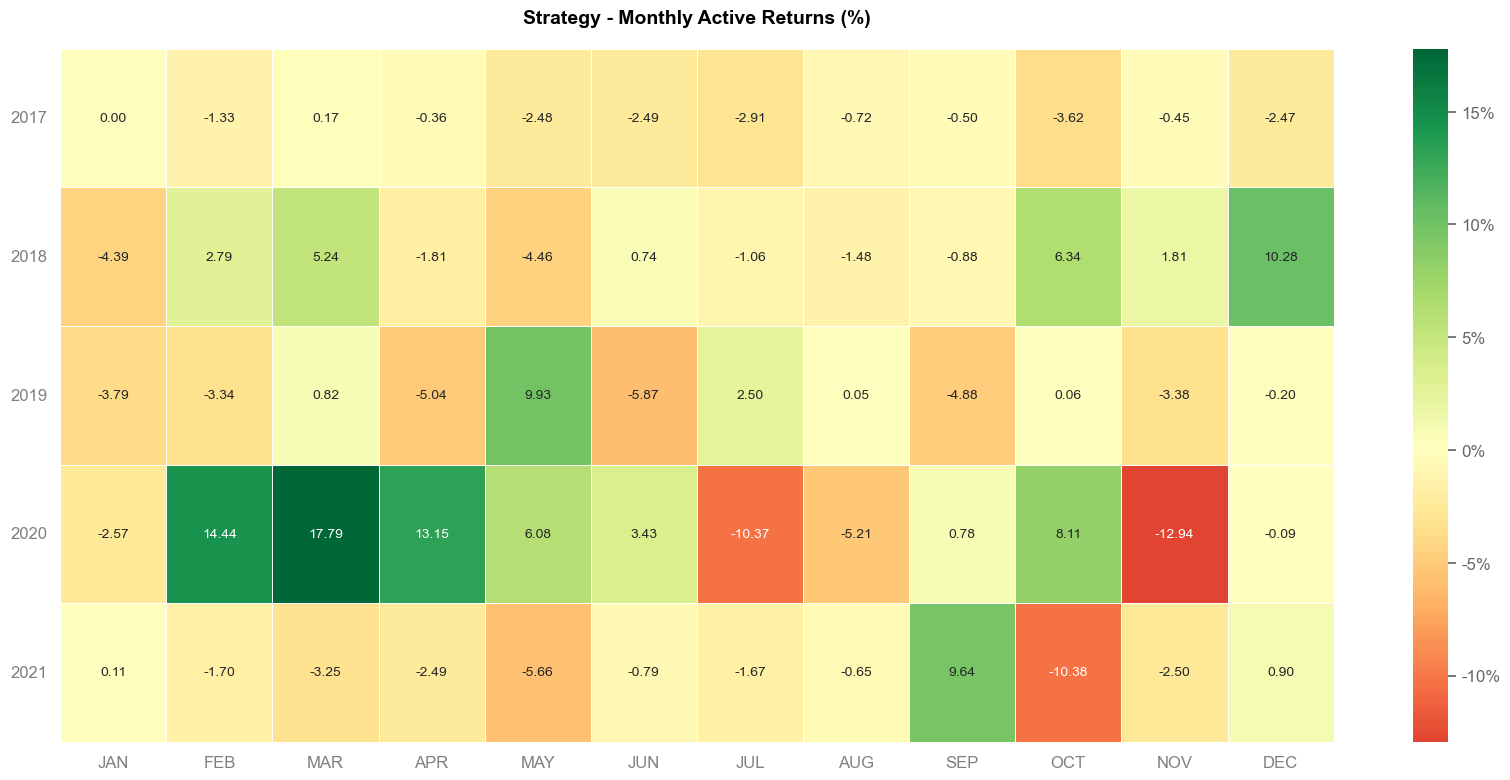

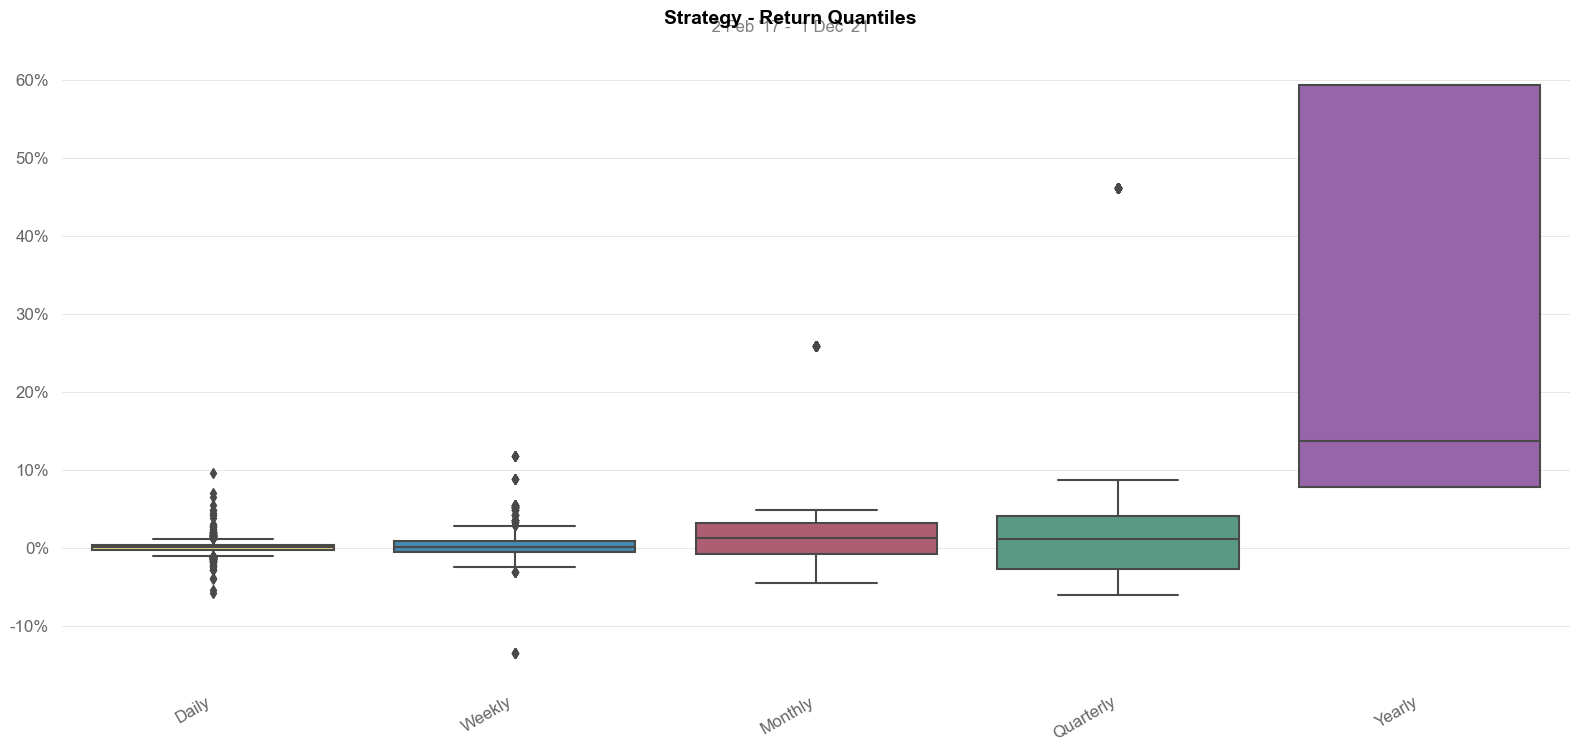

In [13]:
#Statistics report
qs.reports.full(pred_return_opt['totalRet'], spy_return['spyRet'], figsize=(16, 8))
# qs.reports.full(pred_return_opt['totalRet'], spy_return)